# 1) Imports

In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
from os import walk
from os.path import join, exists
from utils import nomes, save_dataframe_as_feather, decode_rle

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN, OPTICS, KMeans, AgglomerativeClustering

import tensorflow
from tensorflow.keras.preprocessing import image

# 2) Carregar dataset

In [4]:
dataset = pd.read_feather('train_com_imagens.feather')
dataset = dataset.sample(frac=1)
dataset

,id,class,segmentation,image,width,height
47735,case24_day25_slice_0053,stomach,29414 7 29679 12 29944 15 30209 17 30473 20 30...,.\train\case24\case24_day25\scans\slice_0053_2...,266,266
62835,case43_day20_slice_0062,stomach,34778 5 35037 14 35301 16 35566 18 35831 20 36...,.\train\case43\case43_day20\scans\slice_0062_2...,266,266
78234,case54_day32_slice_0099,large_bowel,24556 8 24820 12 25085 15 25351 17 25375 5 256...,.\train\case54\case54_day32\scans\slice_0099_2...,266,266
90399,case133_day0_slice_0001,large_bowel,None,.\train\case133\case133_day0\scans\slice_0001_...,360,310
79963,case43_day18_slice_0039,stomach,37698 7 37960 12 38223 15 38487 17 38751 20 39...,.\train\case43\case43_day18\scans\slice_0039_2...,266,266
...,...,...,...,...,...,...
9225,case43_day26_slice_0039,stomach,None,.\train\case43\case43_day26\scans\slice_0039_2...,266,266
45303,case124_day0_slice_0104,small_bowel,26782 1 27047 10 27314 11 27512 3 27539 6 2758...,.\train\case124\case124_day0\scans\slice_0104_...,266,266
65455,case32_day18_slice_0025,large_bowel,None,.\train\case32\case32_day18\scans\slice_0025_2...,266,266
11868,case36_day8_slice_0128,stomach,None,.\train\case36\case36_day8\scans\slice_0128_26...,266,266


# 3) Clusterizar imagens p/ gerar exemplos de teste

In [5]:
distancia_vizinho = 50
n_vizinhos = 100

def new_cluster_model():
	# Demora menos mas consumo de memória é n
	# return DBSCAN(
	# 	eps=distancia_vizinho,
	# 	min_samples=n_vizinhos,
	# 	n_jobs=-2
	# )

	return KMeans(
		n_clusters=10,
	)

	# Demora consideravelmente mas não consome tanta memória
	# return OPTICS(
	# 	cluster_method='dbscan',
	# 	eps=distancia_vizinho,
	# 	min_samples=n_vizinhos,
	# 	n_jobs=-2
	# )

	# Demora + consumo de memória
	# return AgglomerativeClustering(
	# 	n_clusters=10,
	# )

In [33]:
class Counter:
    _count = 0
    @staticmethod
    def get():
        Counter._count += 1
        return Counter._count
    
    @staticmethod
    def reset():
        Counter._count = 0


def clustering(linha, redimensionar=False):
    largura, altura = linha['width'], linha['height']
    # largura, altura = 100, 100

    img = image.load_img(
        linha['image'],
        target_size=(largura, altura),
        color_mode='grayscale'
    )

    # Para realizar o clustering de uma imagem
    # Precisa de uma matriz das posicoes + uma dimensao para cores
    image_as_arr = image.img_to_array(img).reshape(largura * altura, 1)

    print(Counter.get(), end=', ')
    
    # Rodar clustering
    cluster_array = new_cluster_model().fit_predict(image_as_arr)

    if not redimensionar:
        return cluster_array

    cluster_array = cluster_array.reshape(largura, altura)
    cluster_array = np.expand_dims(cluster_array, axis=2)
    cluster_img_raw = image.array_to_img(cluster_array)
    cluster_img_raw.save('cluster.png')

    # Abrir cluster novamente para redimensionar
    cluster_img = image.load_img(
        'cluster.png',
        target_size=(largura, altura),
        color_mode='grayscale'
    )
    return image.img_to_array(cluster_img).reshape(largura * altura, 1)

In [34]:
# Limitar os dados por questão de tempo
# limite_dados = 10000
# limite_dados = 1000
# limite_dados = 100
# limite_dados = 25
limite_dados = 5

df_dados = pd.concat([
	dataset[dataset['class'] == 'stomach'].sample(limite_dados),
	dataset[dataset['class'] == 'small_bowel'].sample(limite_dados),
	dataset[dataset['class'] == 'large_bowel'].sample(limite_dados),
])

df_dados['class'].value_counts()

df_dados['clusters'] = df_dados.apply(clustering, axis=1)
df_dados.head()

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 

,id,class,segmentation,image,width,height,clusters
64527,case2_day4_slice_0077,stomach,19821 3 20081 12 20346 17 20611 19 20876 22 21...,.\train\case2\case2_day4\scans\slice_0077_266_...,266,266,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
70402,case41_day32_slice_0133,stomach,None,.\train\case41\case41_day32\scans\slice_0133_2...,266,266,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
29053,case63_day18_slice_0107,stomach,None,.\train\case63\case63_day18\scans\slice_0107_2...,266,266,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
38100,case65_day28_slice_0098,stomach,None,.\train\case65\case65_day28\scans\slice_0098_2...,266,266,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..."
48706,case29_day13_slice_0015,stomach,None,.\train\case29\case29_day13\scans\slice_0015_2...,266,266,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."


## Visualização

Número clusters: (10,)
Tem segmentação: True


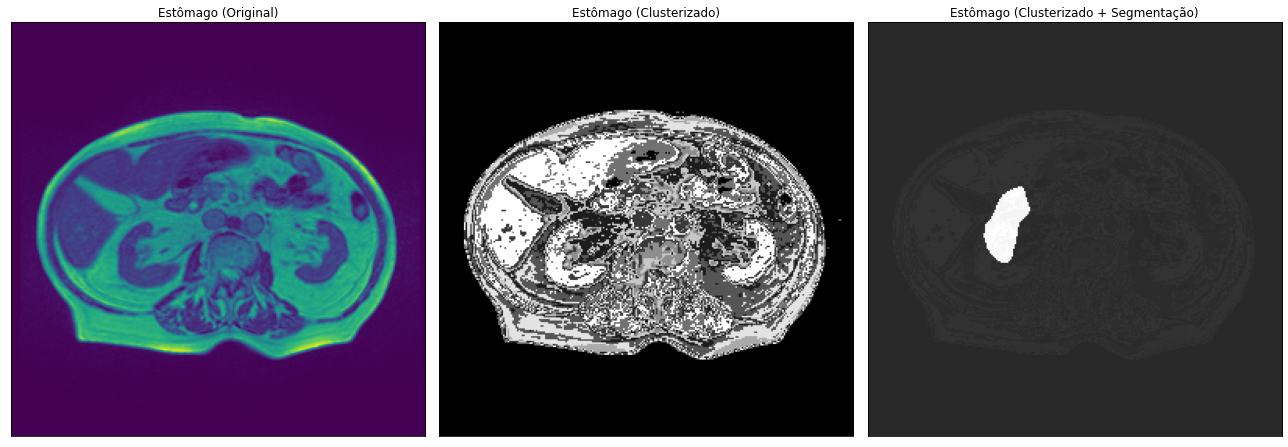

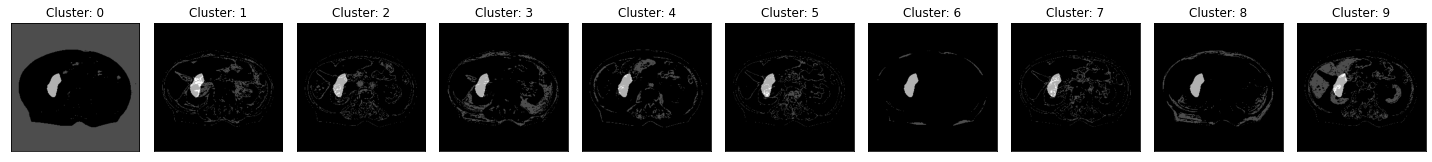

In [36]:
linha = df_dados[df_dados['segmentation'].notnull()].sample(n=1).iloc[0]
largura, altura = linha['width'], linha['height']

print('Número clusters:', pd.DataFrame(linha['clusters']).value_counts().keys().shape)
print('Tem segmentação:', bool(linha['segmentation']))

# Desenhar
fig = plt.figure(figsize=(18, 10))
fig.patch.set_alpha(1)

# Desenho original
ax = plt.subplot(1, 3, 1)
# ax.imshow(image.load_img(linha['image'], target_size=(linha['height'], linha['width'])))
ax.imshow(plt.imread(linha['image']))
plt.xticks([])
plt.yticks([])
plt.title(nomes[linha['class']] + ' (Original)')

# Desenho clusters
ax = plt.subplot(1, 3, 2)
clusters = linha['clusters'].reshape(largura, altura)
ax.imshow(clusters, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title(nomes[linha['class']] + ' (Clusterizado)')
plt.tight_layout()

# Desenho clusters + segmentação
if linha['segmentation']:
	ax = plt.subplot(1, 3, 3)

	ax.imshow(clusters, cmap='gray', alpha=0.2)

	segmentation = linha['segmentation']
	segmentation_rle = decode_rle(segmentation, shape=(altura, largura))

	ax.imshow(
		segmentation_rle,
		cmap='gray',
		alpha=0.8
	)
	plt.xticks([])
	plt.yticks([])
	plt.title(nomes[linha['class']] + ' (Clusterizado + Segmentação)')

	plt.tight_layout()

plt.show()

max_clusters = 10
fig, axs = plt.subplots(1, max_clusters, figsize=(max_clusters * 2, 6))
fig.patch.set_alpha(1)
for i in range(max_clusters):
	cluster_selecionado = i
	d = pd.DataFrame(linha['clusters']).applymap(lambda x: 1 if x == cluster_selecionado else 0)
	d = np.array(d.values).reshape(largura, altura)

	axs[i].imshow(d, cmap='gray')
	axs[i].imshow(segmentation_rle, cmap='gray', alpha=0.7)
	axs[i].set_title(f'Cluster: {cluster_selecionado}')
	axs[i].set_xticks([])
	axs[i].set_yticks([])

plt.tight_layout()

# plt.title(nomes[linha['class']] + ' (Segmentado)')
# plt.show()

# 4) Separar clusters em imagens por pasta

In [213]:
def comparar_cluster_linha(linha):
	largura, altura = linha['width'], linha['height']
	clusters = linha['clusters']
	segmentation = decode_rle(linha['segmentation'], shape=(altura, largura))

	# Transformar de matriz 2d para vetor 1d
	segmentation = segmentation.reshape(1, -1)

	# Pegar apenas os clusters que estão na segmentação
	clusters_segmentacao = clusters * segmentation
	clusters_selecionados = np.unique(clusters_segmentacao)

	print(clusters_selecionados)

	# Contar quantos clusters existem na segmentação
	# np.alguma coisa

comparar_cluster_linha(linha)

[0 1 2 3 4 5 7 9]


TypeError: _apply_along_axis_dispatcher() missing 1 required positional argument: 'func1d'

In [107]:
# save_dataframe_as_feather(df_dados, 'train_imagens_clusters.feather')